# Challenge 02: Minimum Hamming Distance using a Quantum Algorithm

The Hamming distance between two binary strings (with the same number of bits) is defined as the number positions where the bits differ from each other. For example, the Hamming distance between these $6$-bit strings <span style="color:red">$0$</span>$01$<span style="color:red">$0$</span>$0$<span style="color:red">$1$</span> and <span style="color:red">$1$</span>$01$<span style="color:red">$1$</span>$0$<span style="color:red">$0$</span> is $3$.

A simple way to calculate the Hamming distance between two numbers is to perform a bitwise XOR between them, and count the number of ones in the resulting string:

$$ 001001 \oplus 101100 = 100101 \xrightarrow[]{\; \text{count ones} \;} 011 \text{ (3 in base-2)} $$

The purpose of this challenge is to develop a quantum algorithm that takes as an input an arbitrary number $m$ of $n$-bit strings, and outputs the two strings with the minimum Hamming distance between them with a resonably high probability. How high? the higher the better.

For instance, for the following input of four 4-bit strings: $[0000,1001,1100,1101]$ the algorithm should return strings $[1100,1101]$ since they only differ by one bit.

**Level 1:** Start by only considering the cases in which the answer is unique. In other words, assume that all inputs only have one pair of strings that gives the minimum Hamming distance. So inputs such as $[0000,0001,0010,0111]$ don't have to be considered because there are two solutions: $[0000,0001]$ and $[0000,0010]$.

**Level 2:** Now consider the case where more than one solution can exist and make sure the algorithm returns each of the possible solutions with equal probability. So, for the example above, the probability of measuring $[0000,0001]$ or $[0000,0010]$ should be close to $50\%$ (inputs with repeated strings should also be considered).

**Hint:** Consider looking into some of the "textbook" quantum algorithms (like Deutch-Jozsa (DJ) [1], Bernstein-Vazirani (BV) [2], Grover [3], etc.) to see if this problem can be solved with variations of these. Take for instance this pre-print [4], where a modified version of DJ was used to compute Hamming distances between two strings. Now, keep in mind that in that approach, Hamming weights were calculated using probability distributions (which require multiple runs of the algorithm), and not by amplifying states, as required by this challenge.


[1] Deutsch, David, and Richard Jozsa. "Rapid solution of problems by quantum computation." Proceedings of the Royal Society of London. Series A: Mathematical and Physical Sciences 439.1907 (1992): 553-558.

[2] Bernstein, Ethan, and Umesh Vazirani. "Quantum complexity theory." SIAM Journal on computing 26.5 (1997): 1411-1473.

[3] Grover, Lov K. , "A fast quantum mechanical algorithm for database search", Proceedings of the 28th Annual ACM Symposium on the Theory of Computing (1996), [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)

[4] Bravo, José Manuel. "Calculating Hamming distance with the IBM Q Experience." Preprints (2018).

# Example 

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, Aer, IBMQ , QuantumRegister , ClassicalRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from iqx import *

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import numpy as np
import os
from math import pi
import operator

In [3]:
array=['0000','1001','1100','1101']
lista =[]
for i in array:
    #print(i)
    #lista[:0]=str(i)
    for index,j in enumerate(i):
        print(index,j)
    print()

0 0
1 0
2 0
3 0

0 1
1 0
2 0
3 1

0 1
1 1
2 0
3 0

0 1
1 1
2 0
3 1



In [4]:
def position(inputs,valor):
    lista = []
    a = bin(inputs)[2:] 
    while len(a)<valor:
        a = '0'+a
    a=a[::-1]
    #print(a)
    for i in range(len(a)):
        if a[i] == '1':
            lista.append(i)
    return lista

In [5]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

In [6]:
def qram(qc,address,distance_h,array):
    # address 0 -> data = 1
    pos =len(address)
    states = 2**pos
    lista =[]
    count = 0
    for i in array:
        lista = position(count,states)
        for k in lista:
            qc.x(address[k])
        for index,j in enumerate(i):
            if j == '1':
                qc.ccx(address[0],address[1],distance_h[index])
        for k in lista:
            qc.x(address[k])
        qc.barrier()
        
        count+=1
    

In [7]:
def hamming(array):
    n=2
    address_1 = QuantumRegister(n)
    address_2 = QuantumRegister(n)
    distance_h = QuantumRegister(len(array[0]))
    reg_oracle= QuantumRegister(1)
    c_1 = ClassicalRegister(n)
    c_2 = ClassicalRegister(n)
    qc = QuantumCircuit(address_1,address_2, distance_h,reg_oracle, c_1, c_2)
   
    qc.x(reg_oracle)
    qc.h(reg_oracle)
    qc.h(address_1)
    qc.h(address_2)
    #qc.x(distance_h)
    qc.h(distance_h)
    qc.barrier()
    
    qram(qc,address_1,distance_h,array)
    qram(qc,address_2,distance_h,array)
    
    for i in distance_h:
        qc.cx(i,reg_oracle)
    #qc.mct(distance_h,reg_oracle)
    qc.h(distance_h)
    qc.barrier()    
    qram(qc,address_2,distance_h,array)
    qram(qc,address_1,distance_h,array)
    qc.h(distance_h)
    qc.barrier() 
    qc.append(diffuser(2*n),[address_1[0],address_1[1],address_2[0],address_2[1]])
    qc.barrier() 
    qc.measure([address_1[0], address_1[1],address_2[0], address_2[1]], [c_1[0], c_1[1],c_2[0], c_2[1]])
    qc=qc.reverse_bits()
    return qc

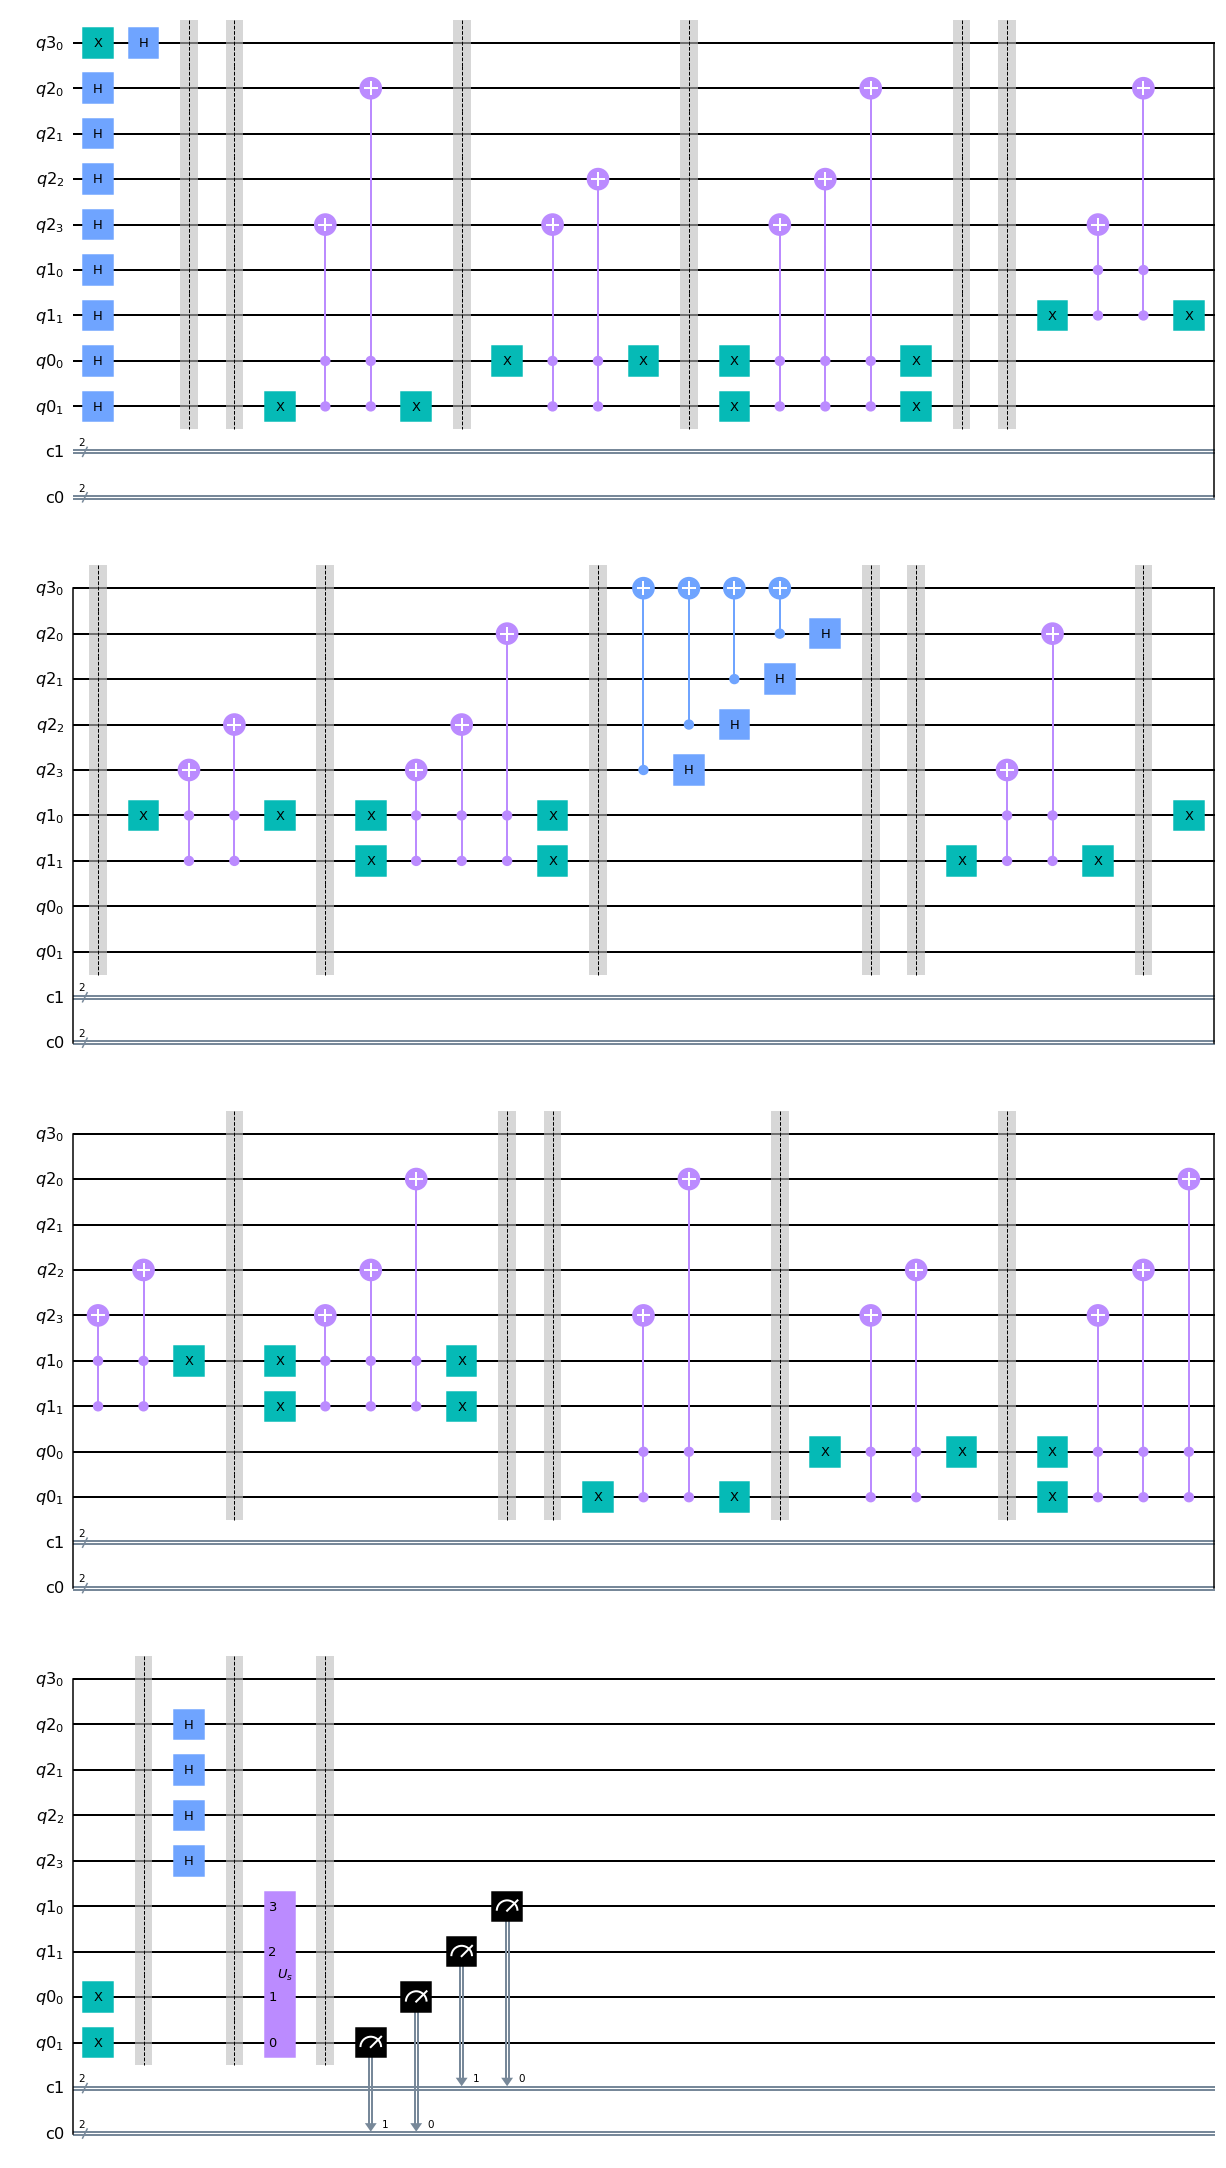

In [8]:
qc = hamming(array)
qc.draw(output='mpl')

In [9]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=81920)
result = job.result()
# Returns counts
counts = result.get_counts(qc)
print(counts)
output = max(counts.items(), key=operator.itemgetter(1))[0]
print(output)

{'00 00': 3232, '00 01': 5758, '00 10': 5758, '00 11': 5736, '01 00': 5720, '01 01': 3261, '01 10': 5723, '01 11': 5670, '10 00': 5942, '10 01': 5768, '10 10': 3231, '10 11': 5772, '11 00': 5655, '11 01': 5700, '11 10': 5728, '11 11': 3266}
10 00


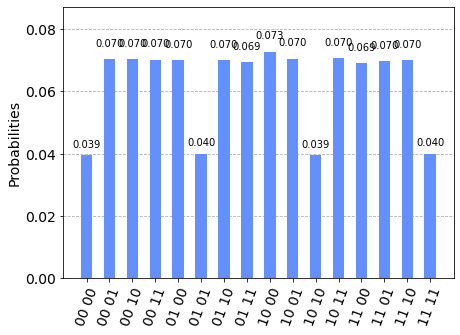

In [10]:
plot_histogram(job.result().get_counts(qc))

In [11]:
result_h = output.split()
index_output = []
for i in result_h:
    index_output.append(int(i, 2))
for j in index_output:
    print(array[j])

1100
0000


# Level 1

In [12]:
def hamming(array):
    n=2
    address_1 = QuantumRegister(n)
    address_2 = QuantumRegister(n)
    distance_h = QuantumRegister(len(array[0]))
    ancilla = QuantumRegister(1)
    ancilla2 = QuantumRegister(1)
    reg_oracle= QuantumRegister(1)
    reg_oracle2= QuantumRegister(1)
    c_1 = ClassicalRegister(n)
    c_2 = ClassicalRegister(n)
    qc = QuantumCircuit(address_1,address_2, distance_h,ancilla,ancilla2,reg_oracle, reg_oracle2, c_1, c_2)
    
    qc.x(reg_oracle)
    qc.h(reg_oracle)
    qc.x(reg_oracle2)
    qc.h(reg_oracle2)
    qc.h(address_1)
    qc.h(address_2)
    qc.h(ancilla)
    qc.h(ancilla2)
    #qc.h(distance_h)
    qc.x(distance_h)
    qc.barrier()
    
    qram(qc,address_1,distance_h,array)
    qram(qc,address_2,distance_h,array)
    
    for i in distance_h:
        qc.cx(i,ancilla2)
    qc.ccx(distance_h[0],distance_h[1],reg_oracle2) 
    qc.ccx(distance_h[2],distance_h[3],reg_oracle2) 
    qc.mct(distance_h,reg_oracle2)
    qc.cx(ancilla2,reg_oracle2)
        
    qc.mct([address_1[0],address_1[1],address_2[0],address_2[1]],ancilla)
    qc.ccx(address_1[0],address_2[0],ancilla)
    qc.ccx(address_1[1],address_2[1],ancilla)
    
    qc.cx(ancilla,reg_oracle)
    #qc.h(distance_h)
    #qc.h(ancilla)
    qc.barrier()    
    qc.append(diffuser(2*n),[address_1[0],address_1[1],address_2[0],address_2[1]])
    qram(qc,address_2,distance_h,array)
    qram(qc,address_1,distance_h,array)
    qc.h(distance_h)
    qc.h(ancilla)
    qc.barrier() 
    
    
    qc.append(diffuser(2*n),[address_1[0],address_1[1],address_2[0],address_2[1]])
    qc.barrier() 
    
    
    qc.measure([address_1[0], address_1[1],address_2[0], address_2[1]], [c_1[0], c_1[1],c_2[0], c_2[1]])
    qc=qc.reverse_bits()
    return qc

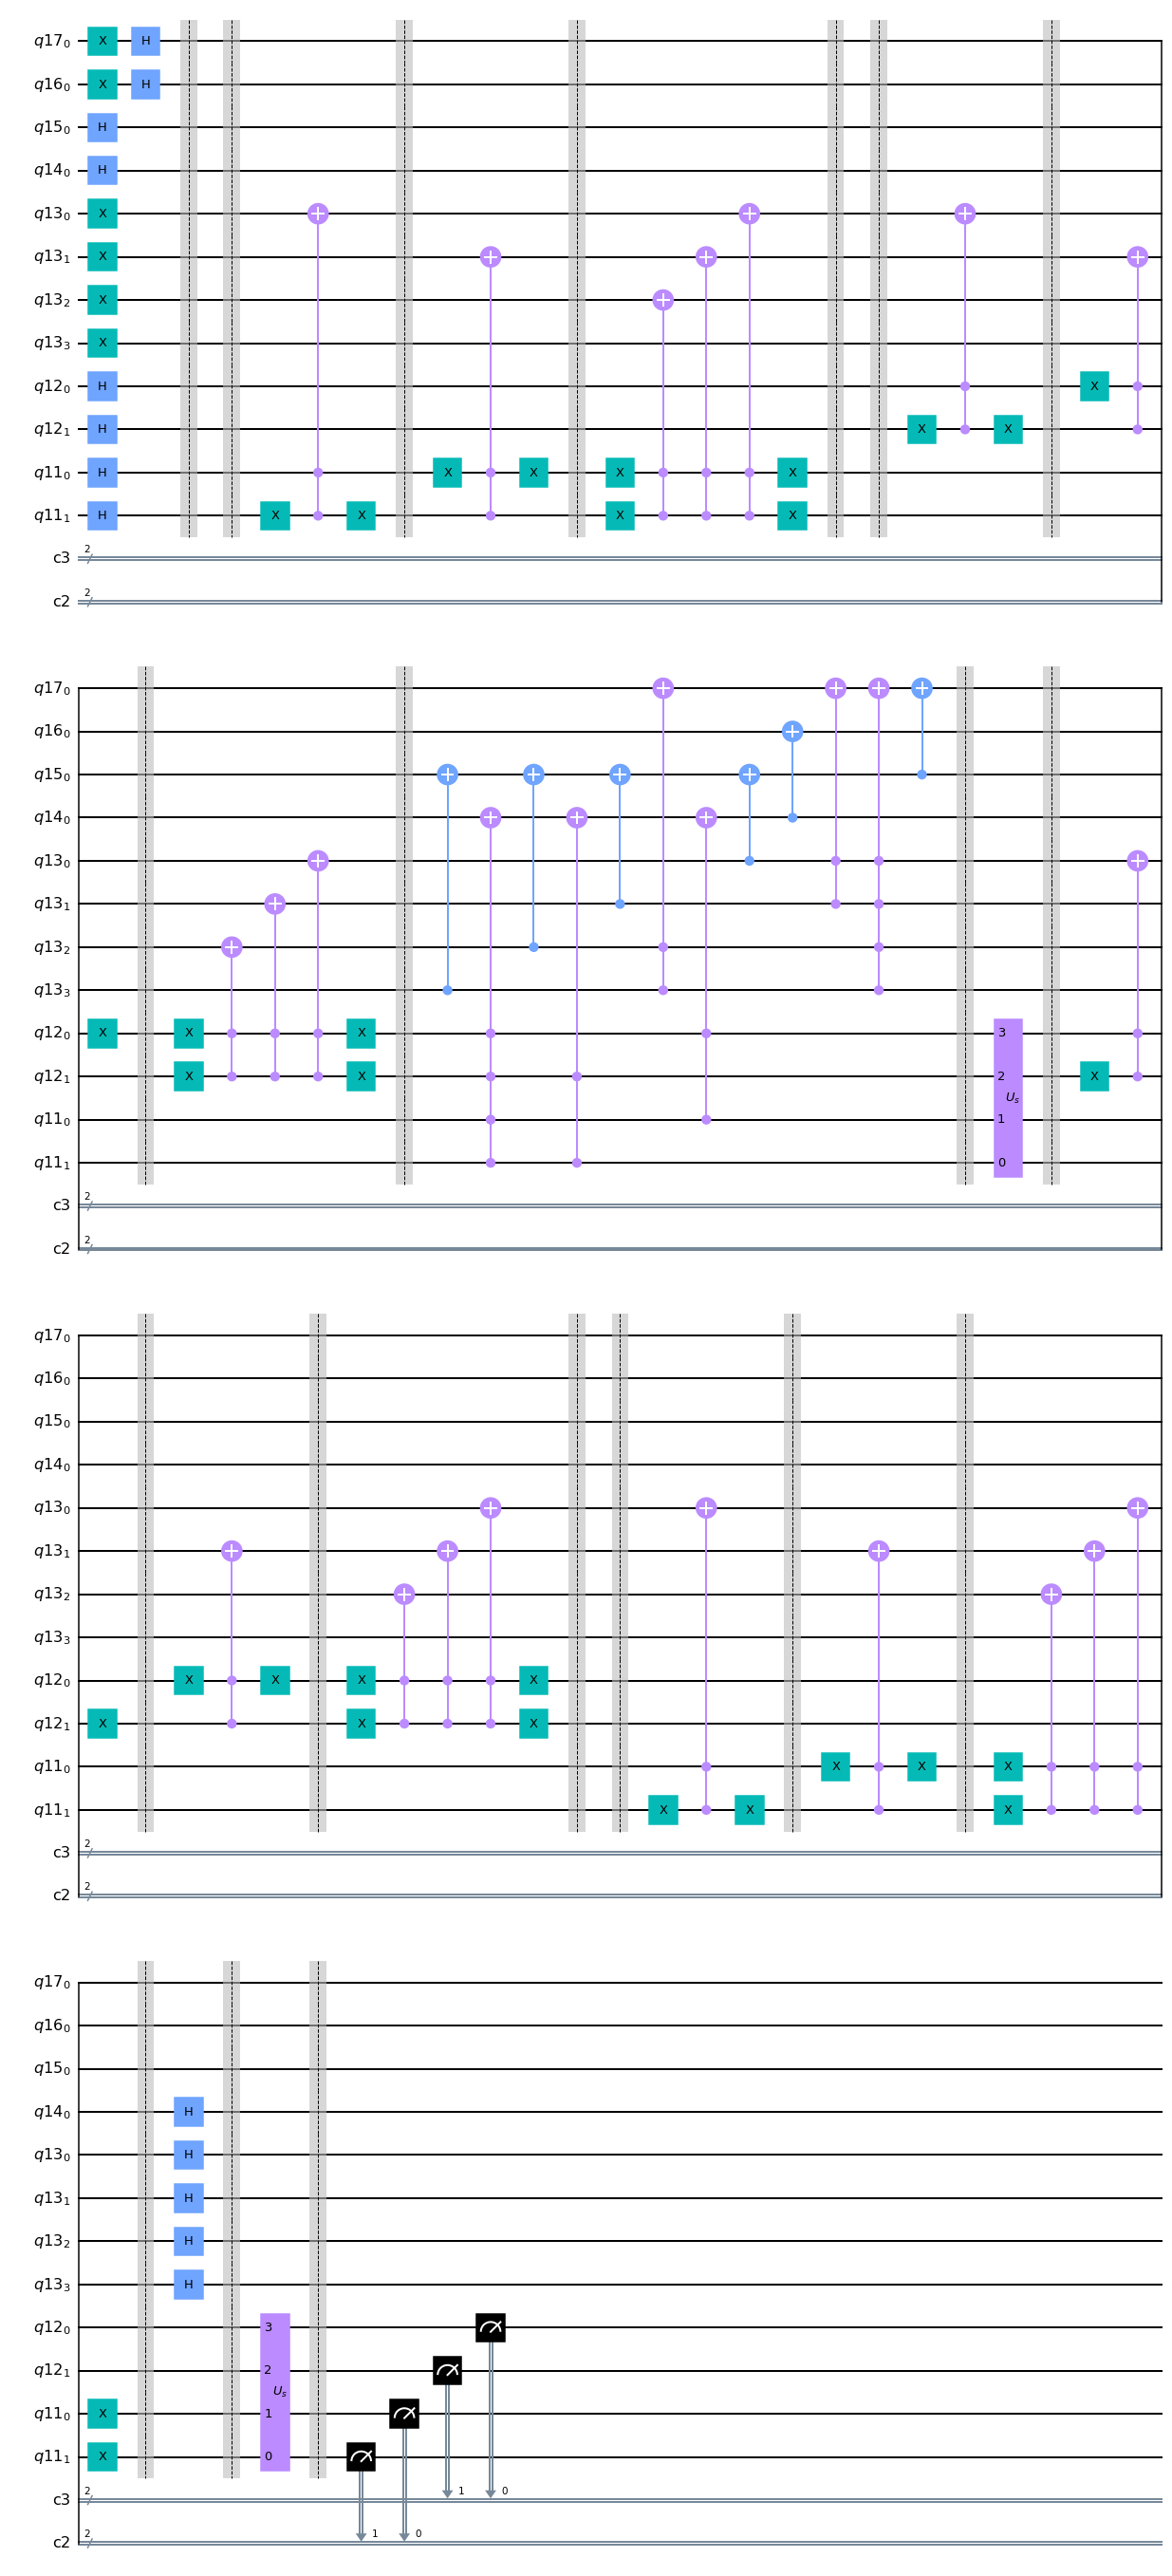

In [13]:
array2=['0000','0001','0010','0111']
qc = hamming(array2)
qc.draw(output='mpl')

In [14]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=81920)
result = job.result()
# Returns counts
counts = result.get_counts(qc)
print(counts)
output = max(counts.items(), key=operator.itemgetter(1))[0]
print(output)

{'00 00': 1343, '00 01': 10274, '00 10': 10134, '00 11': 10187, '01 00': 10335, '01 01': 1304, '01 10': 2551, '01 11': 2603, '10 00': 10371, '10 01': 2589, '10 10': 1275, '10 11': 2547, '11 00': 10167, '11 01': 2485, '11 10': 2496, '11 11': 1259}
10 00


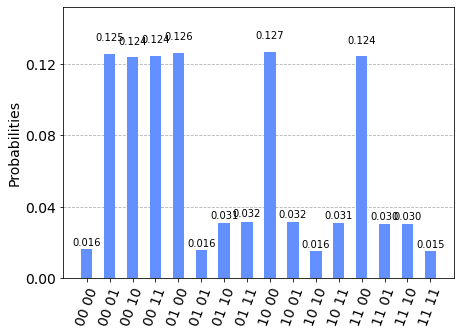

In [15]:
plot_histogram(job.result().get_counts(qc))

In [16]:
result_h = output.split()
index_output = []
for i in result_h:
    index_output.append(int(i, 2))
for j in index_output:
    print(array2[j])

0010
0000


# Level 2

Each result will have two outputs representing the same output

In [506]:
def hamming2(array):
    n=2
    address_1 = QuantumRegister(n)
    address_2 = QuantumRegister(n)
    distance_h = QuantumRegister(len(array[0]))
    reg_oracle= QuantumRegister(1)
    c_1 = ClassicalRegister(n)
    c_2 = ClassicalRegister(n)
    qc = QuantumCircuit(address_1,address_2, distance_h,reg_oracle, c_1, c_2)
   
    qc.x(reg_oracle)
    qc.h(reg_oracle)
    qc.h(address_1)
    qc.h(address_2)
    #qc.x(distance_h)
    qc.barrier()
    qram(qc,address_1,distance_h,array)
    qram(qc,address_2,distance_h,array)
        
    
    qc.h(distance_h)
    qc.barrier()
    for i in distance_h:
        qc.cx(i,reg_oracle)
    #qc.mct(distance_h,reg_oracle)
    qc.h(distance_h)
    qc.barrier()
    
   # qc.x(distance_h[1])
    #qc.x(distance_h[2])
    qc.x(distance_h[3])
    qc.mct(distance_h,reg_oracle)
    #qc.x(distance_h[1])
   # qc.x(distance_h[2])
    qc.x(distance_h[3])    
    qc.barrier()    

    qc.x(distance_h[0])
   # qc.x(distance_h[1])
  #  qc.x(distance_h[2])
    qc.mct(distance_h,reg_oracle)
    qc.x(distance_h[0])
   # qc.x(distance_h[1])
  #  qc.x(distance_h[2])    
    qc.barrier() 
    
   # qc.x(distance_h[0])
    qc.x(distance_h[2])
   # qc.x(distance_h[3])
    qc.mct(distance_h,reg_oracle)
   # qc.x(distance_h[0])
    qc.x(distance_h[2])
   # qc.x(distance_h[3])    
    qc.barrier()
    
    qc.x(distance_h[1])
  #  qc.x(distance_h[2])
  #  qc.x(distance_h[0])
    qc.mct(distance_h,reg_oracle)
    qc.x(distance_h[1])
 #   qc.x(distance_h[2])
 #   qc.x(distance_h[0])    
    qc.barrier() 
    
    qc.h(distance_h)
    qc.barrier()
    for i in distance_h:
        qc.cx(i,reg_oracle)
    #qc.mct(distance_h,reg_oracle)
    qc.h(distance_h)
    qc.barrier()
    
    qram(qc,address_2,distance_h,array)
    qram(qc,address_1,distance_h,array)
    qc.barrier() 
    qc.append(diffuser(2*n),[address_1[0],address_1[1],address_2[0],address_2[1]])
    qc.barrier() 
    qc.x(address_1)
    qc.x(address_2)
    qc.measure([address_1[0], address_1[1],address_2[0], address_2[1]], [c_1[0], c_1[1],c_2[0], c_2[1]])
    qc=qc.reverse_bits()
    return qc

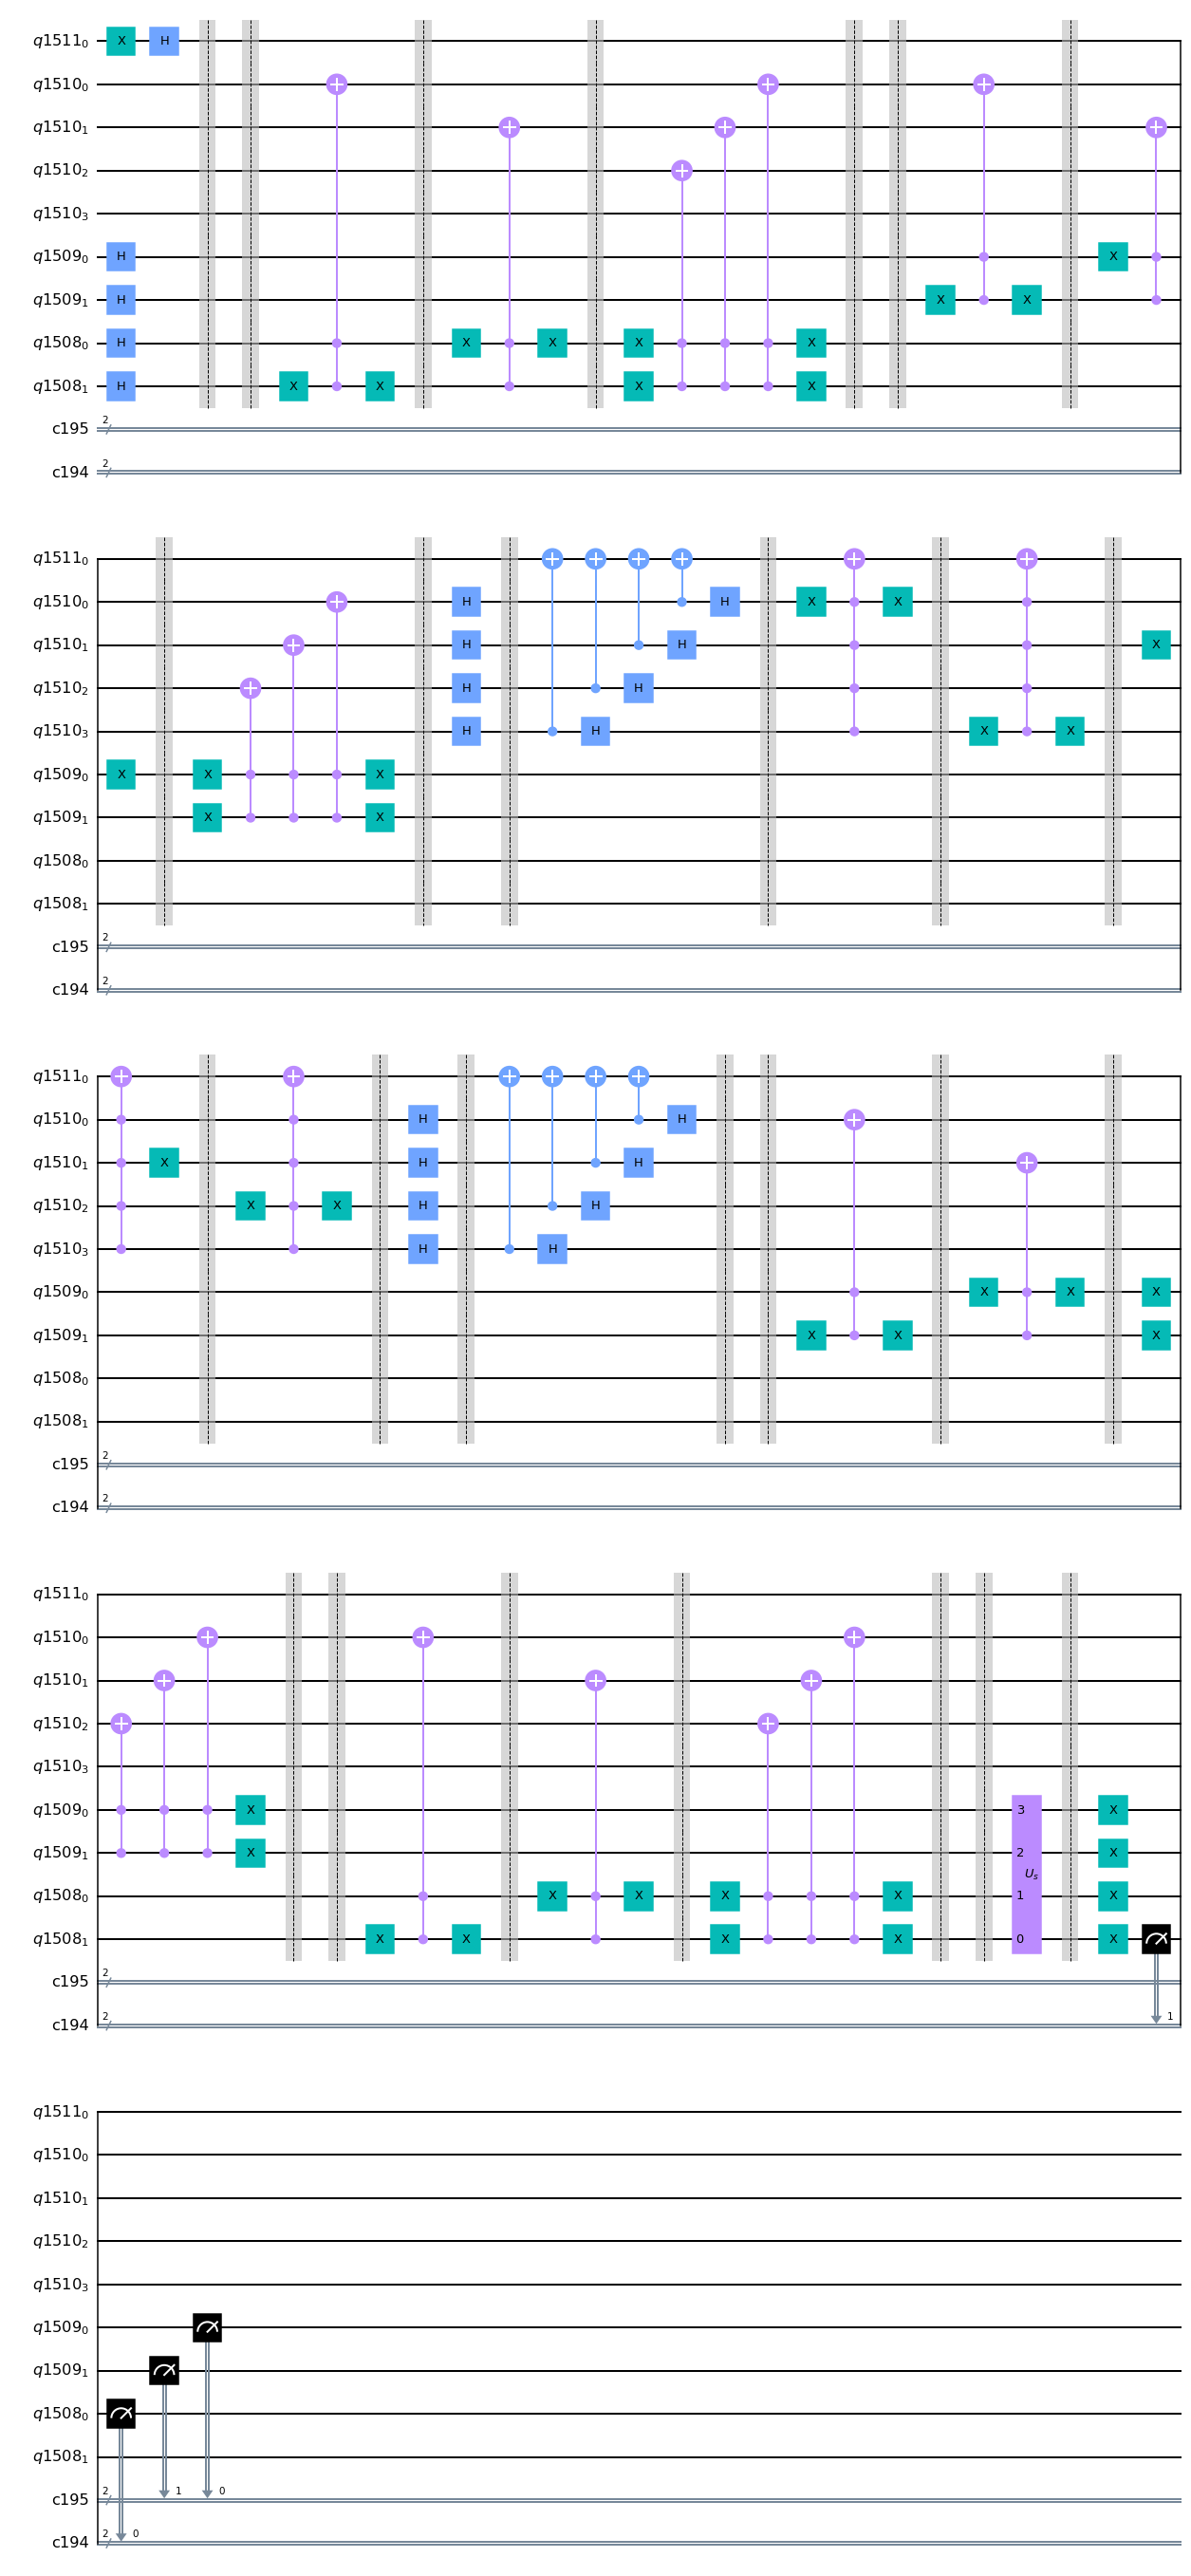

In [507]:
array2=['0000','0001','0010','0111']
qc = hamming2(array2)
qc.draw(output='mpl')

In [508]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=81920)
result = job.result()
# Returns counts
counts = result.get_counts(qc)
print(counts)
output = max(counts.items(), key=operator.itemgetter(1))[0]
print(output)

{'00 01': 20385, '00 10': 20497, '01 00': 20353, '10 00': 20685}
10 00


In [509]:
outputs =  dict(sorted(counts.items(), key=lambda item: item[1]))

outputs

{'01 00': 20353, '00 01': 20385, '00 10': 20497, '10 00': 20685}

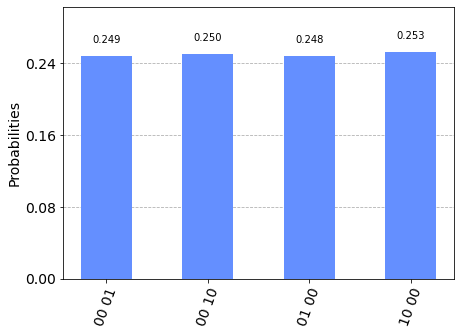

In [510]:
plot_histogram(job.result().get_counts(qc))

In [511]:
result_h = output.split()
index_output = []
for i in result_h:
    index_output.append(int(i, 2))
for j in index_output:
    print(array2[j])

0010
0000


## Level 2 qith example's input 

In [512]:
array=['0000','1001','1100','1101']
qc = hamming2(array)
qc.draw(output='mpl')
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=81920)
result = job.result()
# Returns counts
counts = result.get_counts(qc)
print(counts)
output = max(counts.items(), key=operator.itemgetter(1))[0]
print(output)
outputs =  dict(sorted(counts.items(), key=lambda item: item[1]))
print(outputs)

{'01 11': 20322, '10 11': 20525, '11 01': 20575, '11 10': 20498}
11 01
{'01 11': 20322, '11 10': 20498, '10 11': 20525, '11 01': 20575}


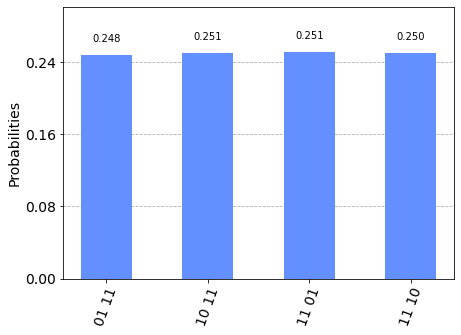

In [513]:
plot_histogram(job.result().get_counts(qc))

In [514]:
result_h = output.split()
index_output = []
for i in result_h:
    index_output.append(int(i, 2))
for j in index_output:
    print(array2[j])

0111
0001
